In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


## Import m·ªôt s·ªë th∆∞ vi·ªán c·∫ßn thi·∫øt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
#from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
# ƒê·ªçc file csv
df = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')
df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [4]:
df.shape

(35887, 3)

### Ki·ªÉm tra s·ªë l∆∞·ª£ng ·∫£nh m·ªù, nhi·ªÖu trong dataset

In [5]:
df['pixels_array'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.float32))
df['pixel_mean'] = df['pixels_array'].apply(np.mean)
df['pixel_std'] = df['pixels_array'].apply(np.std)

In [6]:
# M·ªù = mean < 40 v√† std < 15
blurred_df = df[(df['pixel_mean'] < 40) & (df['pixel_std'] < 15)]
print(f"S·ªë l∆∞·ª£ng ·∫£nh m·ªù: {len(blurred_df)}")


S·ªë l∆∞·ª£ng ·∫£nh m·ªù: 16


In [7]:
# Nhi·ªÖu = std > 70
noisy_df = df[df['pixel_std'] > 70]
print(f"S·ªë l∆∞·ª£ng ·∫£nh nghi nhi·ªÖu: {len(noisy_df)}")


S·ªë l∆∞·ª£ng ·∫£nh nghi nhi·ªÖu: 4486


## X√≥a ·∫£nh m·ªù v√† l√†m m∆∞·ª£t ·∫£nh b·ªã nhi·ªÖu

In [8]:
import cv2
import numpy as np
blurred_idx = blurred_df.index  # danh s√°ch index ·∫£nh m·ªù
noisy_idx = noisy_df.index      # danh s√°ch index ·∫£nh nhi·ªÖu
def process_pixel_array(pixels_array, idx, blurred_idx, noisy_idx):
    img = np.array(pixels_array).reshape(48, 48).astype(np.uint8)

    if idx in blurred_idx:
        return None  # Xo√° ·∫£nh m·ªù

    if idx in noisy_idx:
        img = cv2.medianBlur(img, 3)  # L√†m m∆∞·ª£t ·∫£nh nghi nhi·ªÖu

    img = cv2.resize(img, (160, 160), interpolation=cv2.INTER_CUBIC)
    img_rgb = np.stack([img]*3, axis=-1)
    return img_rgb


In [9]:
clean_images = []
clean_labels = []

for idx, row in df.iterrows():
    img = process_pixel_array(row['pixels_array'], idx, blurred_idx, noisy_idx)
    if img is not None:
        clean_images.append(img)
        clean_labels.append(row['emotion'])

## Ki·ªÉm tra c√°c ·∫£nh ƒë√£ x·ª≠ l√Ω hay ch∆∞a

In [10]:
print(f"T·ªïng s·ªë ·∫£nh ban ƒë·∫ßu: {len(df)}")

T·ªïng s·ªë ·∫£nh ban ƒë·∫ßu: 35887


In [11]:
print(f"T·ªïng s·ªë ·∫£nh sau x·ª≠ l√Ω: {len(clean_images)}")

T·ªïng s·ªë ·∫£nh sau x·ª≠ l√Ω: 35871


In [12]:
print(f"S·ªë ·∫£nh m·ªù b·ªã lo·∫°i: {len(blurred_idx)}")
print(f"S·ªë ·∫£nh nhi·ªÖu ƒë∆∞·ª£c l√†m m∆∞·ª£t: {len(noisy_idx)}")

S·ªë ·∫£nh m·ªù b·ªã lo·∫°i: 16
S·ªë ·∫£nh nhi·ªÖu ƒë∆∞·ª£c l√†m m∆∞·ª£t: 4486


## Ki·ªÉm tra c√°c ·∫£nh b·ªã l·ªói

In [13]:
# Th·ªëng k√™ th√™m
df['pixel_min'] = df['pixels_array'].apply(np.min)
df['pixel_max'] = df['pixels_array'].apply(np.max)

# ƒê·∫∑t ƒëi·ªÅu ki·ªán lo·∫°i ·∫£nh l·ªói
def is_corrupted(row):
    mean = row['pixel_mean']
    std = row['pixel_std']
    min_val = row['pixel_min']
    max_val = row['pixel_max']
    return (
        mean < 10 or
        mean > 245 or
        std < 5 or
        (max_val - min_val) < 20 or
        max_val < 30 or
        min_val > 225
    )

df['corrupted'] = df.apply(is_corrupted, axis=1)

# T√°ch ·∫£nh s·∫°ch v√† l·ªói
corrupted_df = df[df['corrupted']]
clean_df = df[~df['corrupted']]

print(f"S·ªë ·∫£nh l·ªói b·ªã lo·∫°i b·ªè: {len(corrupted_df)}")
print(f"S·ªë ·∫£nh c√≤n l·∫°i sau khi lo·∫°i: {len(clean_df)}")


S·ªë ·∫£nh l·ªói b·ªã lo·∫°i b·ªè: 20
S·ªë ·∫£nh c√≤n l·∫°i sau khi lo·∫°i: 35867


## G√°n nh√£n d·ªØ li·ªáu

In [14]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'sadness',
                5: 'surprise', 6: 'neutral'}

## ki·ªÉm tra s·ªë ·∫£nh b·ªã g√°n nh√£n sai

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_all_classes(df, label_to_text, n_samples=10, outlier_std_thresh=2):
    from scipy.stats import zscore

    # T√≠nh z-score ƒë·ªÉ t√¨m outlier
    df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
    df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)

    classes = sorted(df['emotion'].unique())

    for cls in classes:
        print(f"\n Class {cls} - {label_to_text[cls]}")

        # Hi·ªÉn th·ªã ·∫£nh ng·∫´u nhi√™n trong class
        samples = df[df['emotion'] == cls].sample(n_samples, random_state=42)
        print(f" {n_samples} ·∫£nh ng·∫´u nhi√™n:")
        for _, row in samples.iterrows():
            img = np.array(row['pixels_array']).reshape(48, 48)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(label_to_text[cls])
            plt.show()

        # Hi·ªÉn th·ªã c√°c ·∫£nh nghi l√† outlier theo pixel
        outliers = df[(df['emotion'] == cls) & ((np.abs(df['z_mean']) > outlier_std_thresh) | (np.abs(df['z_std']) > outlier_std_thresh))]
        print(f" ·∫¢nh nghi outlier: {len(outliers)}")
        for _, row in outliers.head(n_samples).iterrows():
            img = np.array(row['pixels_array']).reshape(48, 48)
            plt.imshow(img, cmap='gray')



 Class 0 - Anger
 5 ·∫£nh ng·∫´u nhi√™n:


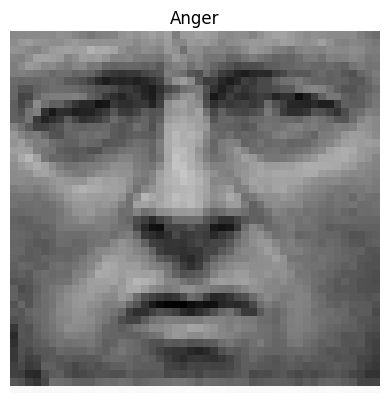

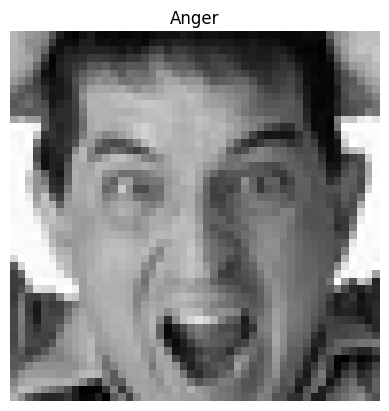

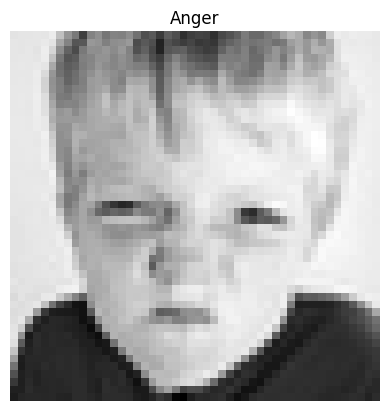

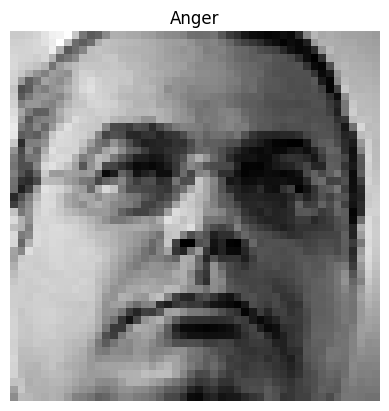

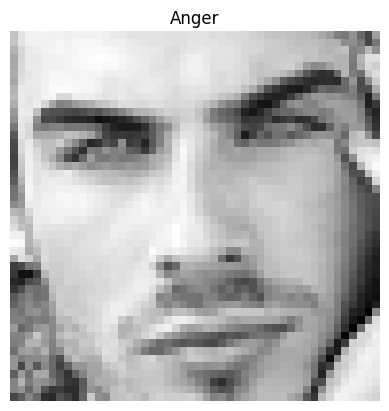

 ·∫¢nh nghi outlier: 397

 Class 1 - Disgust
 5 ·∫£nh ng·∫´u nhi√™n:


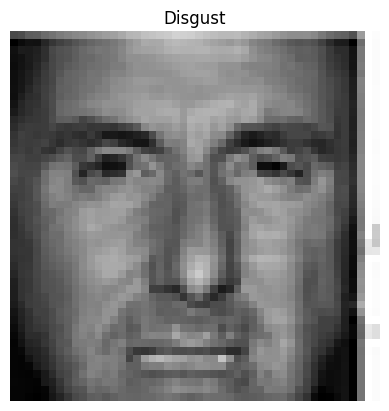

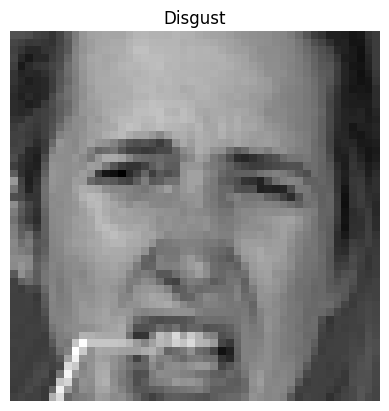

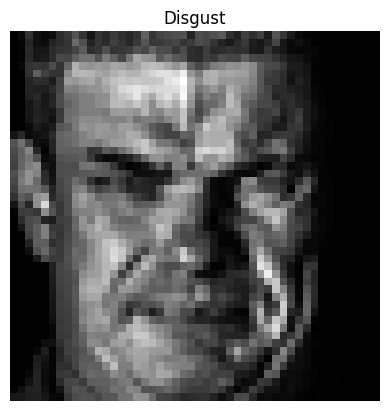

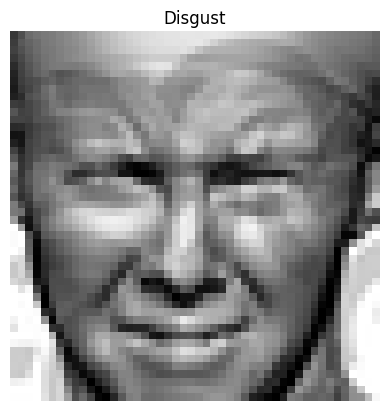

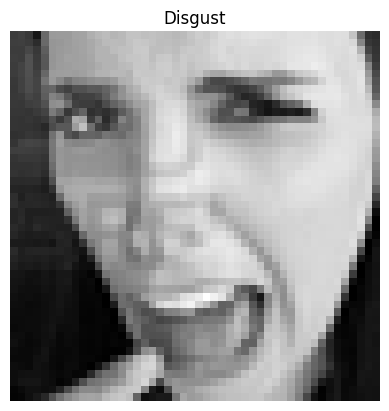

 ·∫¢nh nghi outlier: 34

 Class 2 - Fear
 5 ·∫£nh ng·∫´u nhi√™n:


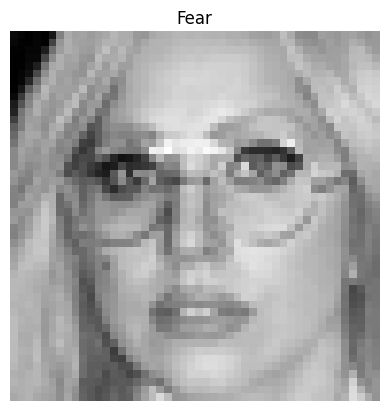

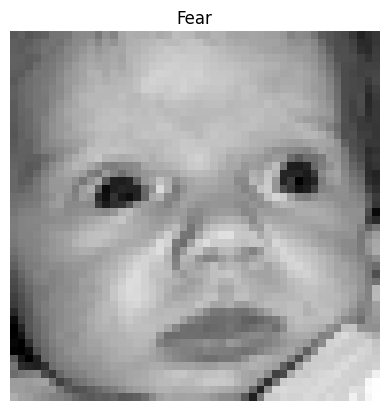

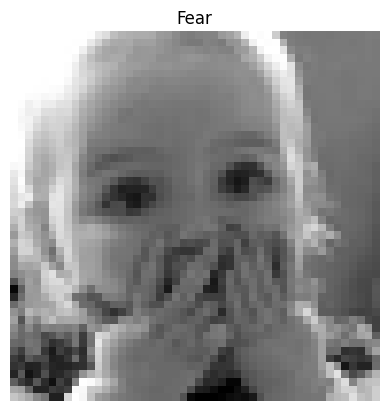

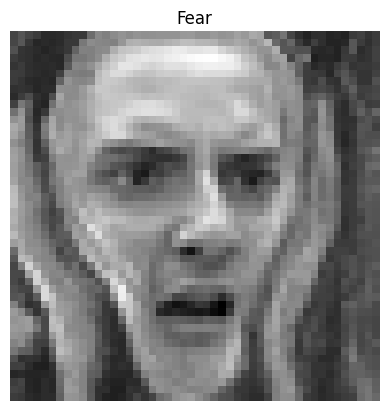

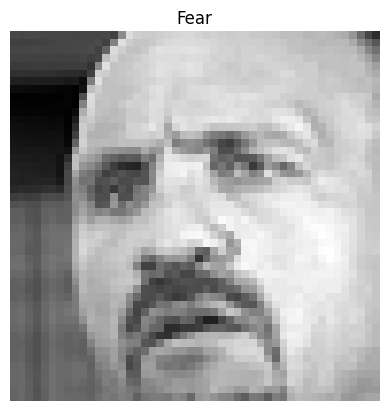

 ·∫¢nh nghi outlier: 378

 Class 3 - Happiness
 5 ·∫£nh ng·∫´u nhi√™n:


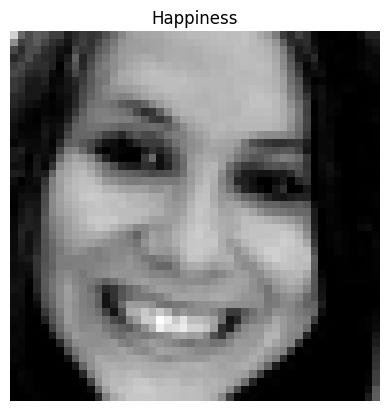

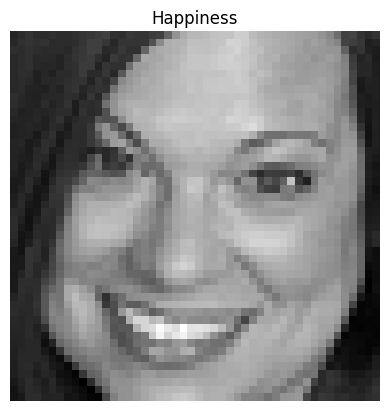

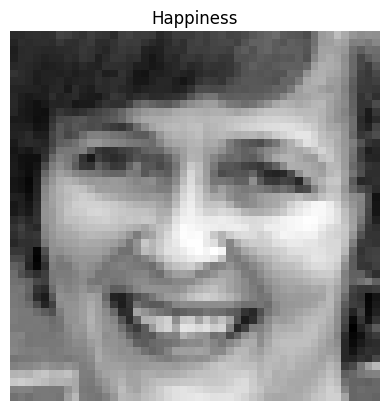

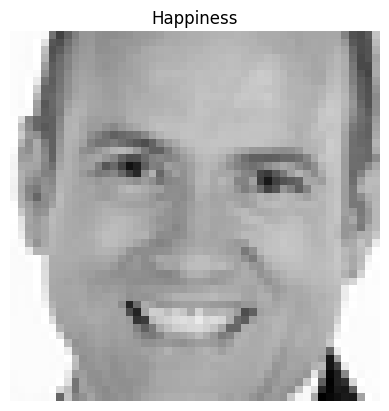

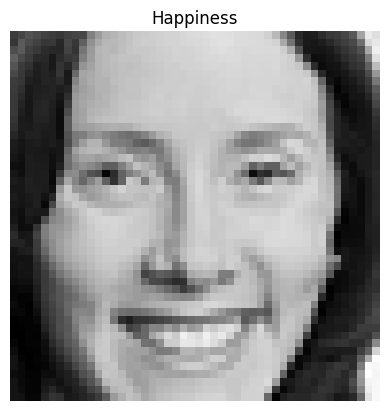

 ·∫¢nh nghi outlier: 722

 Class 4 - sadness
 5 ·∫£nh ng·∫´u nhi√™n:


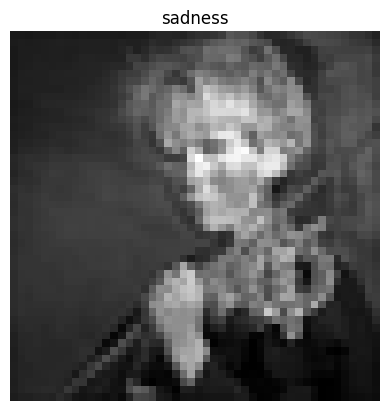

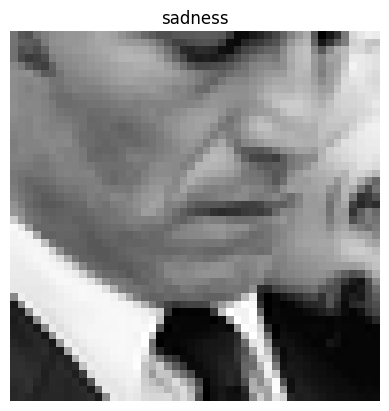

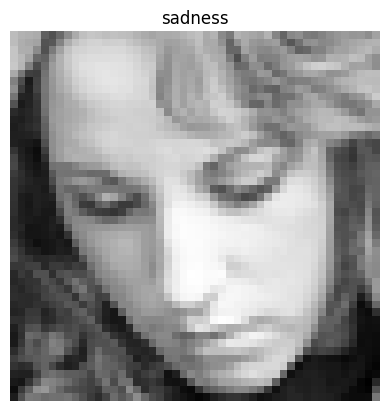

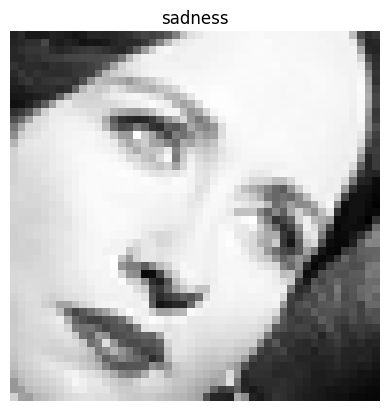

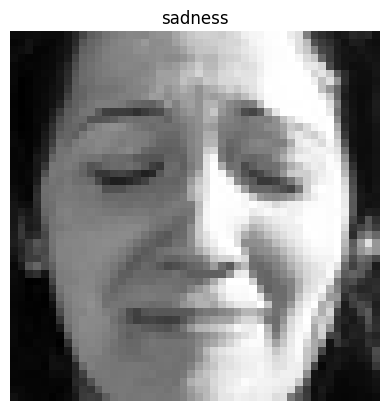

 ·∫¢nh nghi outlier: 502

 Class 5 - surprise
 5 ·∫£nh ng·∫´u nhi√™n:


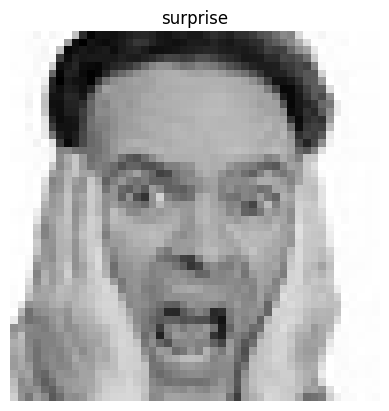

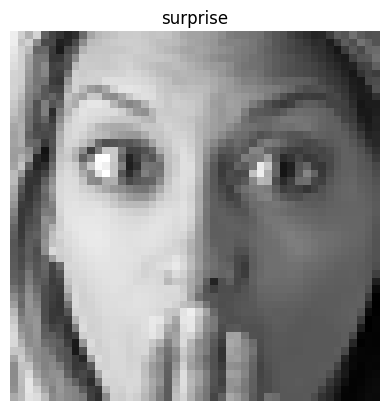

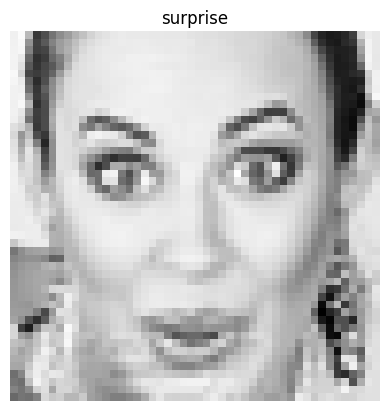

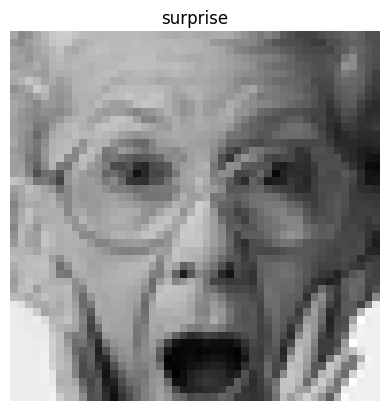

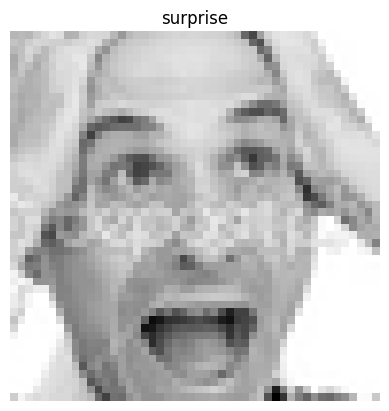

 ·∫¢nh nghi outlier: 301

 Class 6 - neutral
 5 ·∫£nh ng·∫´u nhi√™n:


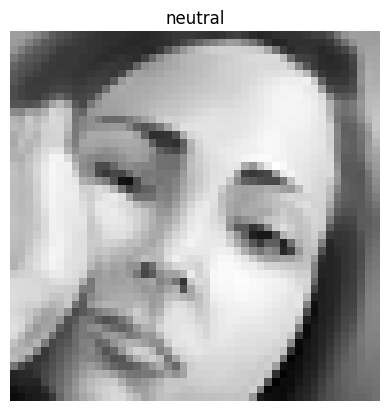

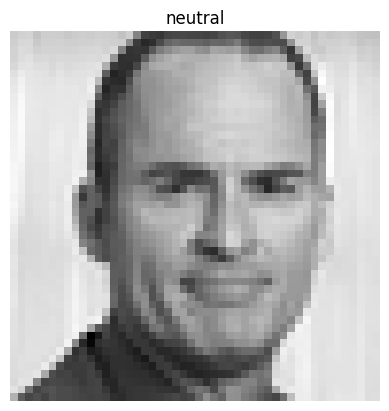

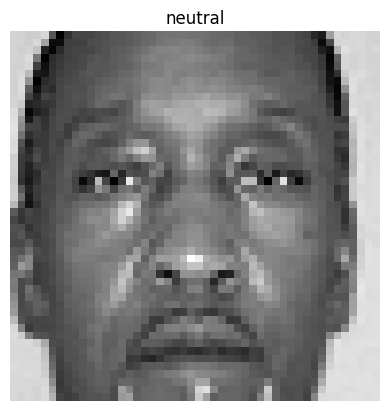

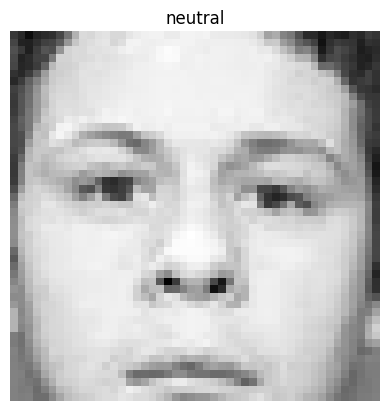

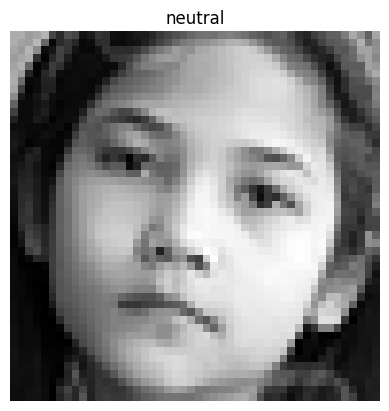

 ·∫¢nh nghi outlier: 478


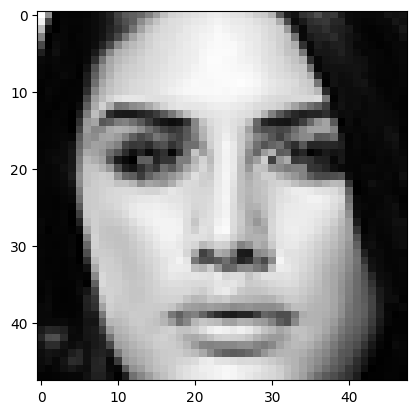

In [16]:
inspect_all_classes(df, label_to_text, n_samples=5, outlier_std_thresh=2)

## Lo·∫°i b·ªè outlier

In [17]:
from scipy.stats import zscore

# T√≠nh z-score theo t·ª´ng class
df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)


In [18]:
# Ti√™u ch√≠ lo·∫°i b·ªè: |z-score c·ªßa pixel_mean| > 2 (ho·∫∑c 3)
#ho·∫∑c |z-score c·ªßa pixel_std| > 2 (ho·∫∑c 3)
threshold = 2  # ho·∫∑c 3 n·∫øu b·∫°n mu·ªën gi·ªØ l·∫°i nhi·ªÅu h∆°n

# X√°c ƒë·ªãnh ch·ªâ s·ªë outlier
outlier_idx = df[(df['z_mean'].abs() > threshold) | (df['z_std'].abs() > threshold)].index

# T·∫°o DataFrame s·∫°ch
df_clean = df.drop(index=outlier_idx)

print(f"S·ªë ·∫£nh b·ªã lo·∫°i v√¨ outlier: {len(outlier_idx)}")
print(f"S·ªë ·∫£nh c√≤n l·∫°i sau khi l·ªçc: {len(df_clean)}")


S·ªë ·∫£nh b·ªã lo·∫°i v√¨ outlier: 2812
S·ªë ·∫£nh c√≤n l·∫°i sau khi l·ªçc: 33075


## Hi·ªÉn th·ªã ·∫£nh tr∆∞·ªõc khi training

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# Hi·ªÉn th·ªã ·∫£nh sau khi x·ª≠ l√Ω data
def show_clean_samples(df_clean, label_to_text, n_samples=5):
    fig = plt.figure(figsize=(18, 18))
    k = 1
    num_classes = df_clean['emotion'].nunique()

    for label in sorted(df_clean['emotion'].unique()):
        samples = df_clean[df_clean['emotion'] == label].sample(n_samples, random_state=42)

        for _, row in samples.iterrows():
            pixels = np.array(row['pixels_array']).reshape(48, 48)  # gi·∫£ s·ª≠ b·∫°n ƒë√£ c√≥ pixels_array
            ax = plt.subplot(num_classes, n_samples, k)
            ax.imshow(pixels, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label_to_text[label])
            k += 1

    plt.tight_layout()
    plt.show()


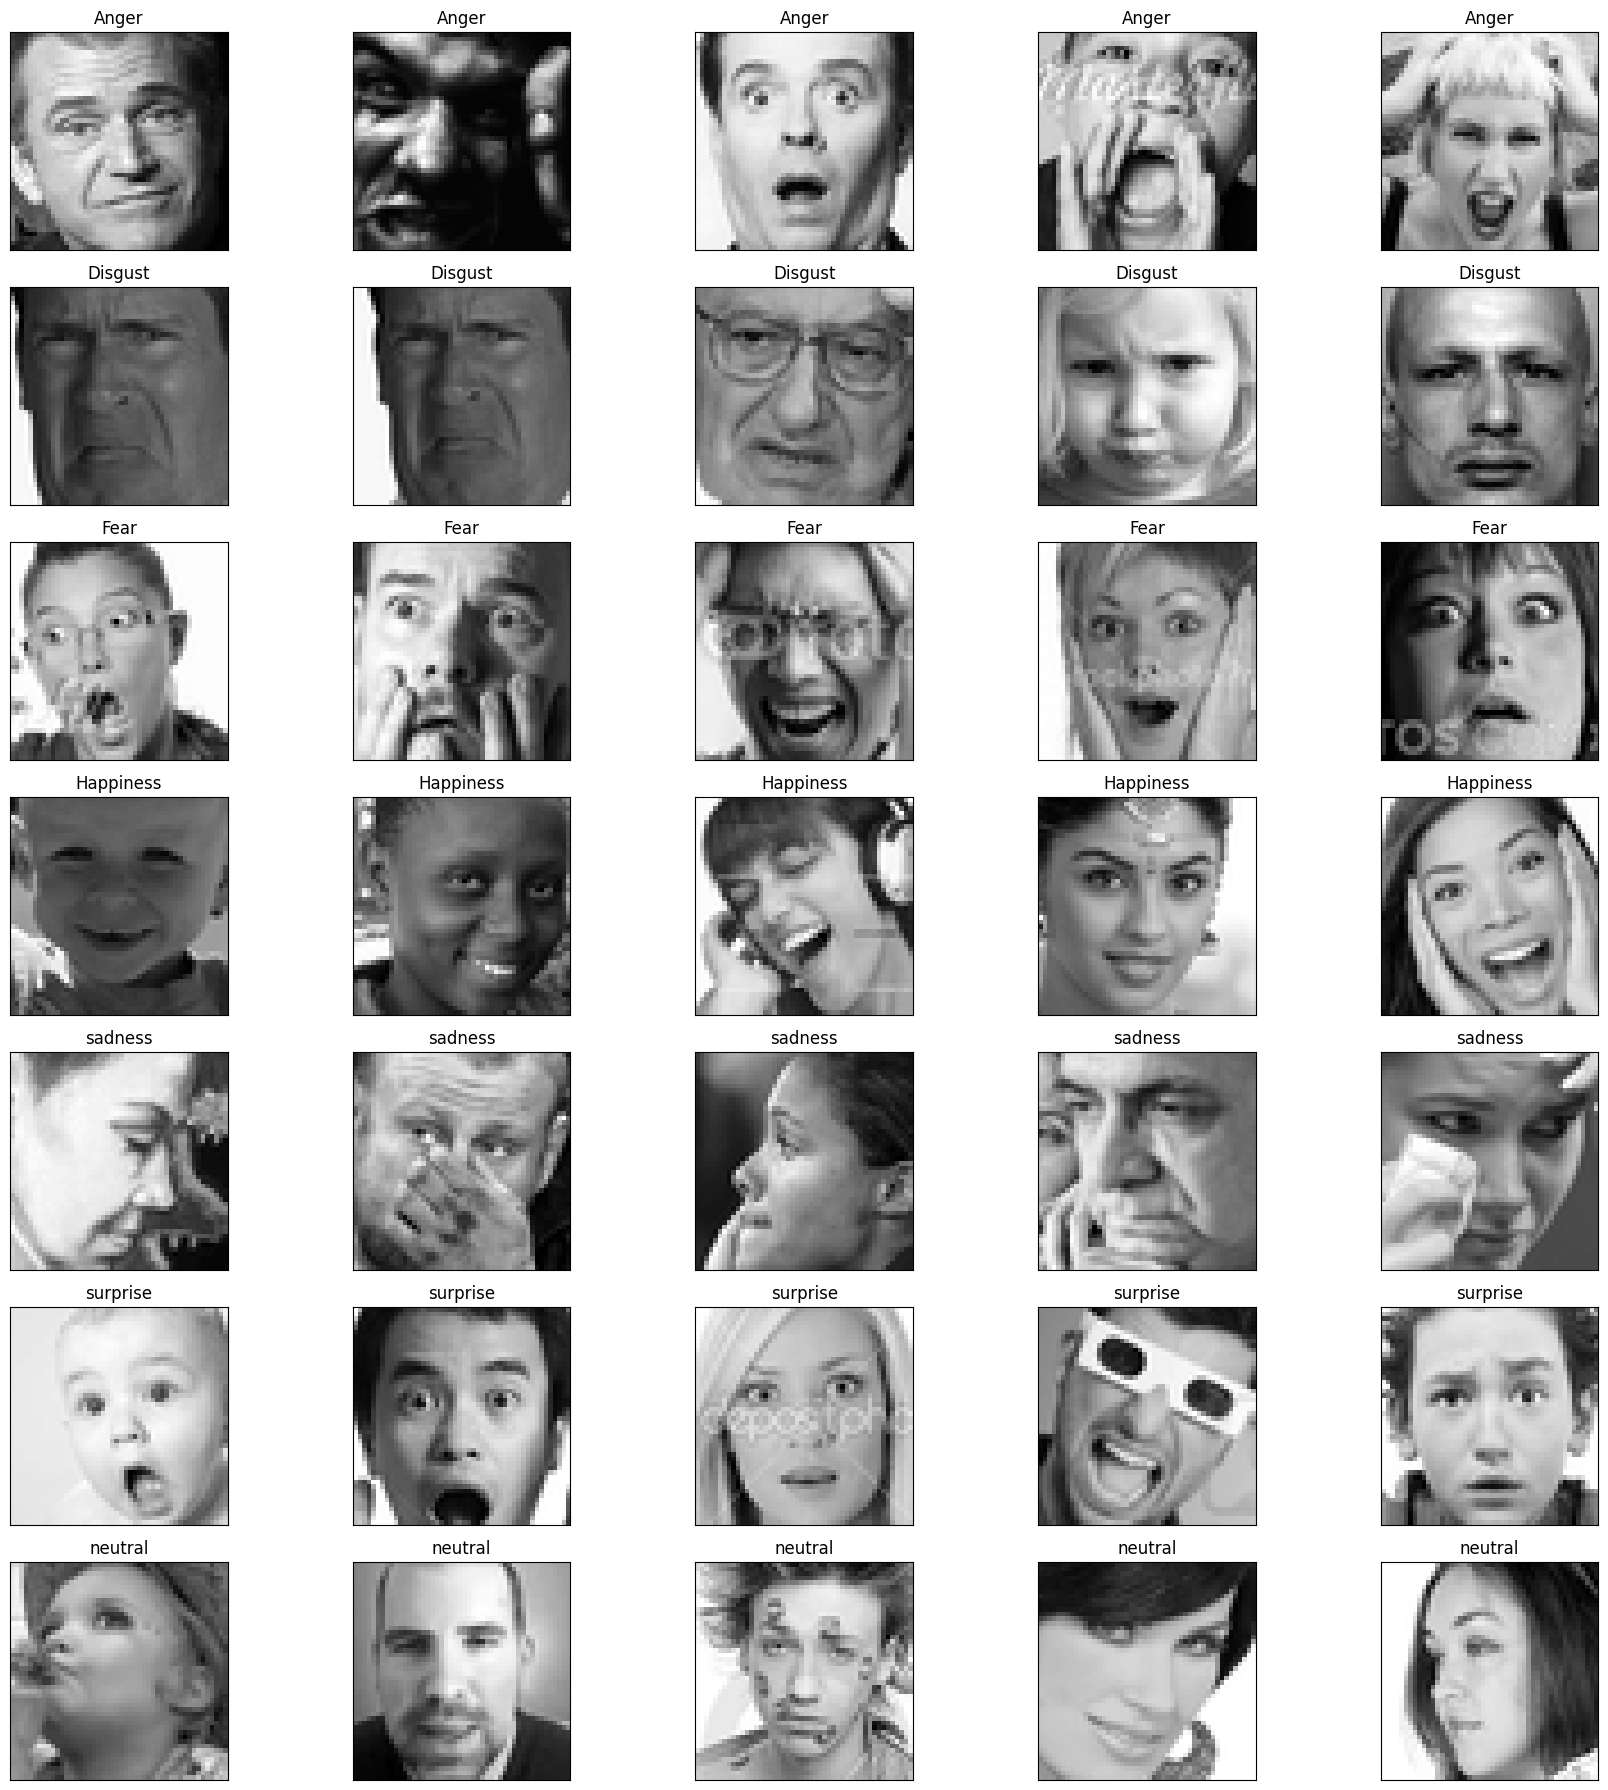

In [20]:
show_clean_samples(df_clean, label_to_text, n_samples=5)

## S·ªë l∆∞·ª£ng emotion ·ªü m·ªói class

In [21]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [22]:
# Split the data into features and target variable

X_data = df['pixels']
y_data = df['emotion']

In [23]:
df.isnull().sum()

emotion         0
pixels          0
Usage           0
pixels_array    0
pixel_mean      0
pixel_std       0
pixel_min       0
pixel_max       0
corrupted       0
z_mean          0
z_std           0
dtype: int64

In [24]:
X_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35887, dtype: object

In [25]:
# Normalize the data
x_data = np.array(list(map(str.split, X_data)), np.float32)
x_data

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]], dtype=float32)

In [26]:
x_data = x_data/255

In [27]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(35887, 48, 48, 1)

In [28]:
# Split the data into train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.2, random_state = 42)

In [29]:
x_train.shape, x_test.shape, y_train.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709,))

In [30]:
from keras.utils import to_categorical

2025-06-26 14:11:39.182594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750947099.408431      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750947099.475125      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [31]:
# Perfom one-hot encoding on labels
y_train_encoded = to_categorical(y_train, 7)
y_train_encoded.shape

(28709, 7)

In [32]:
y_test_encoded = to_categorical(y_test, 7)
y_test_encoded.shape

(7178, 7)

In [33]:
x_data_rgb = np.repeat(x_data, 3, axis=-1)  # chuy·ªÉn (48, 48, 1) ‚Üí (48, 48, 3)


In [34]:
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)


In [35]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
class FERCSV_Dataset(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None, image_size=224):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = int(row['emotion'])
        pixels = np.fromstring(row['pixels'], dtype=np.uint8, sep=' ').reshape(48, 48)
        image = cv2.resize(pixels, (self.image_size, self.image_size), interpolation=cv2.INTER_LANCZOS4)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = torch.tensor(image / 255.0, dtype=torch.float).permute(2, 0, 1)

        return image, label

class FERDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, image_size=224):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.image_size = image_size
        
        self._load_dataset()
    
    def _load_dataset(self):
        mode_dir = os.path.join(self.root_dir, self.mode)
        class_dirs = os.listdir(mode_dir)
        
        for class_idx, class_name in enumerate(sorted(class_dirs)):
            class_path = os.path.join(mode_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LANCZOS4)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label


In [36]:
from torch.utils.data import DataLoader

def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(-0.0625, 0.0625), rotate=(-15, 15), p=0.4),
        A.OneOf([
            A.GaussNoise(p=0.3),
            A.GaussianBlur(blur_limit=(3, 7)),
        ], p=0.4),
        A.OneOf([
            A.CLAHE(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.4),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_val_transform():
    return A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


In [37]:
def calculate_class_weights(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())

    import numpy as np
    class_counts = np.bincount(np.array(all_labels))
    total = len(all_labels)
    n_classes = len(class_counts)
    weights = total / (n_classes * class_counts)
    return torch.FloatTensor(weights)


In [38]:
from torch.utils.data import DataLoader

def get_train_val_loaders_from_csv(csv_path, batch_size=64, image_size=224, num_workers=2):
    train_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="Training",
        transform=get_train_transform(),
        image_size=image_size
    )

    val_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="PublicTest",
        transform=get_val_transform(),
        image_size=image_size
    )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [39]:
csv_path = "/kaggle/input/fer2013/fer2013.csv"
train_loader, val_loader = get_train_val_loaders_from_csv(csv_path)


In [40]:
test_dataset = FERCSV_Dataset(
    csv_path=csv_path,
    usage="PrivateTest",
    transform=get_val_transform()
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


## Model 

In [41]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.nn as nn
class EfficientFER(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(EfficientFER, self).__init__()

        # Load EfficientNetV2-S backbone v·ªõi pretrained weights
        self.backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()  # lo·∫°i b·ªè classifier g·ªëc

        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientFER().to(device)
criterion = nn.CrossEntropyLoss()  # ho·∫∑c d√πng class_weights n·∫øu c·∫ßn
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 82.7M/82.7M [00:00<00:00, 189MB/s]


In [43]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f"üîÅ EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [44]:
from tqdm import tqdm
# Kh·ªüi t·∫°o bi·∫øn l∆∞u l·ªãch s·ª≠
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        loop.set_postfix(loss=train_loss, acc=train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f" Epoch {epoch+1}/{num_epochs} ‚Äî Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # L∆∞u l·∫°i l·ªãch s·ª≠
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Gi·∫£m LR + Early stop
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(" Early stopping triggered.")
        break

Epoch 1/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.11it/s]


 Epoch 1/100 ‚Äî Train Loss: 1.3837, Acc: 0.4640 | Val Loss: 1.1236, Acc: 0.5874


Epoch 2/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.16it/s]


 Epoch 2/100 ‚Äî Train Loss: 1.1581, Acc: 0.5642 | Val Loss: 1.1329, Acc: 0.5698
üîÅ EarlyStopping counter: 1/5


Epoch 3/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 3/100 ‚Äî Train Loss: 1.0619, Acc: 0.6074 | Val Loss: 1.0129, Acc: 0.6163


Epoch 4/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 4/100 ‚Äî Train Loss: 1.0160, Acc: 0.6240 | Val Loss: 0.9750, Acc: 0.6361


Epoch 5/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 5/100 ‚Äî Train Loss: 0.9768, Acc: 0.6371 | Val Loss: 0.9894, Acc: 0.6250
üîÅ EarlyStopping counter: 1/5


Epoch 6/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 6/100 ‚Äî Train Loss: 0.9473, Acc: 0.6484 | Val Loss: 0.9214, Acc: 0.6609


Epoch 7/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.11it/s]


 Epoch 7/100 ‚Äî Train Loss: 0.9176, Acc: 0.6635 | Val Loss: 0.9187, Acc: 0.6629


Epoch 8/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 8/100 ‚Äî Train Loss: 0.8969, Acc: 0.6687 | Val Loss: 0.9541, Acc: 0.6539
üîÅ EarlyStopping counter: 1/5


Epoch 9/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 9/100 ‚Äî Train Loss: 0.8714, Acc: 0.6796 | Val Loss: 0.9331, Acc: 0.6648
üîÅ EarlyStopping counter: 2/5


Epoch 10/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 10/100 ‚Äî Train Loss: 0.8487, Acc: 0.6877 | Val Loss: 0.9059, Acc: 0.6709


Epoch 11/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 11/100 ‚Äî Train Loss: 0.8189, Acc: 0.6986 | Val Loss: 0.9282, Acc: 0.6598
üîÅ EarlyStopping counter: 1/5


Epoch 12/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 12/100 ‚Äî Train Loss: 0.8069, Acc: 0.7034 | Val Loss: 0.8853, Acc: 0.6807


Epoch 13/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 13/100 ‚Äî Train Loss: 0.7832, Acc: 0.7152 | Val Loss: 0.9032, Acc: 0.6709
üîÅ EarlyStopping counter: 1/5


Epoch 14/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 14/100 ‚Äî Train Loss: 0.7601, Acc: 0.7213 | Val Loss: 0.9437, Acc: 0.6748
üîÅ EarlyStopping counter: 2/5


Epoch 15/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 15/100 ‚Äî Train Loss: 0.7395, Acc: 0.7315 | Val Loss: 0.8880, Acc: 0.6773
üîÅ EarlyStopping counter: 3/5


Epoch 16/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.12it/s]


 Epoch 16/100 ‚Äî Train Loss: 0.7222, Acc: 0.7395 | Val Loss: 0.8938, Acc: 0.6760
üîÅ EarlyStopping counter: 4/5


Epoch 17/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 17/100 ‚Äî Train Loss: 0.5971, Acc: 0.7866 | Val Loss: 0.8560, Acc: 0.7008


Epoch 18/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.14it/s]


 Epoch 18/100 ‚Äî Train Loss: 0.5444, Acc: 0.8062 | Val Loss: 0.8700, Acc: 0.7072
üîÅ EarlyStopping counter: 1/5


Epoch 19/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.13it/s]


 Epoch 19/100 ‚Äî Train Loss: 0.5129, Acc: 0.8182 | Val Loss: 0.8837, Acc: 0.7072
üîÅ EarlyStopping counter: 2/5


Epoch 20/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.16it/s]


 Epoch 20/100 ‚Äî Train Loss: 0.4851, Acc: 0.8283 | Val Loss: 0.8930, Acc: 0.7038
üîÅ EarlyStopping counter: 3/5


Epoch 21/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.15it/s]


 Epoch 21/100 ‚Äî Train Loss: 0.4689, Acc: 0.8325 | Val Loss: 0.9139, Acc: 0.7058
üîÅ EarlyStopping counter: 4/5


Epoch 22/100 [Val]: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:13<00:00,  4.13it/s]

 Epoch 22/100 ‚Äî Train Loss: 0.4380, Acc: 0.8445 | Val Loss: 0.9119, Acc: 0.7108
üîÅ EarlyStopping counter: 5/5
 Early stopping triggered.


## ƒê√°nh gi√° tr√™n t·∫≠p test

In [45]:
# ƒê√°nh gi√° tr√™n t·∫≠p test
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    test_loop = tqdm(test_loader, desc=" Evaluating on Test Set")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_correct += (outputs.argmax(1) == labels).sum().item()
        test_total += labels.size(0)

# T√≠nh to√°n trung b√¨nh
test_loss /= test_total
test_acc = test_correct / test_total

print(f" Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_acc:.4f}")


 Evaluating on Test Set: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 57/57 [00:18<00:00,  3.12it/s]

 Test Loss: 0.8458
 Test Accuracy: 0.7261


## Bi·ªÉu ƒë·ªì sau khi hu·∫•n luy·ªán 

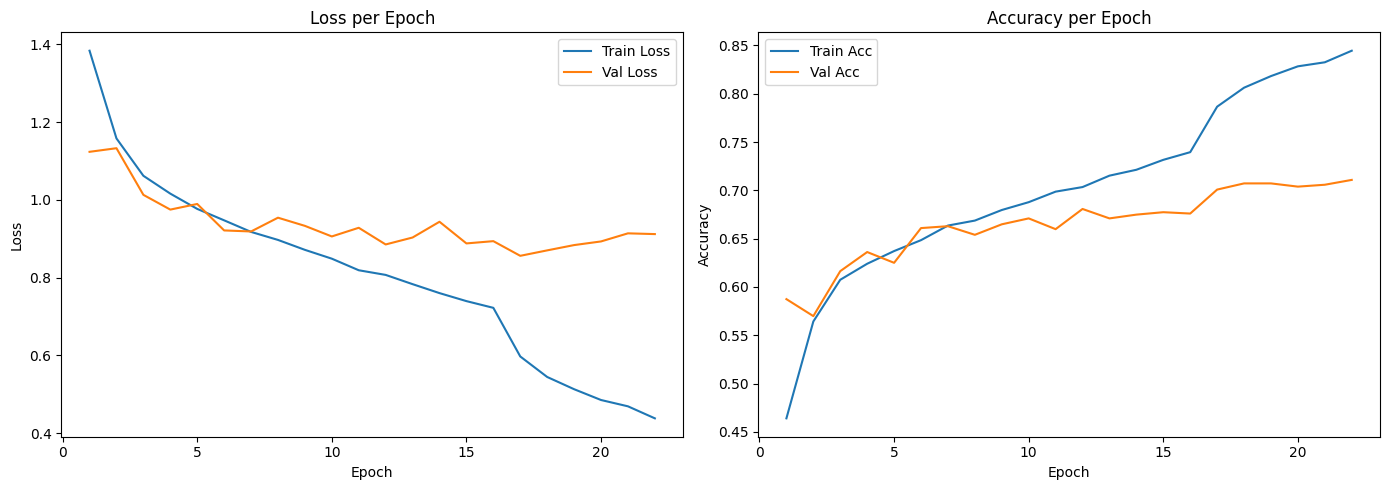

In [46]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


## Ma tr·∫≠n nh·∫ßm l·∫´n


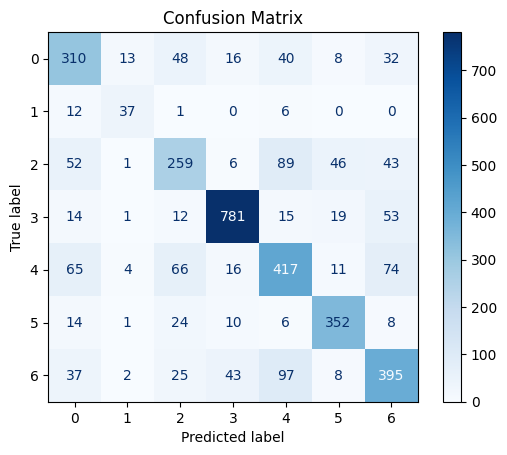

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# D·ª± ƒëo√°n tr√™n t·∫≠p validation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Hi·ªÉn th·ªã ma tr·∫≠n nh·∫ßm l·∫´n
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Predict ·∫£nh sau khi test

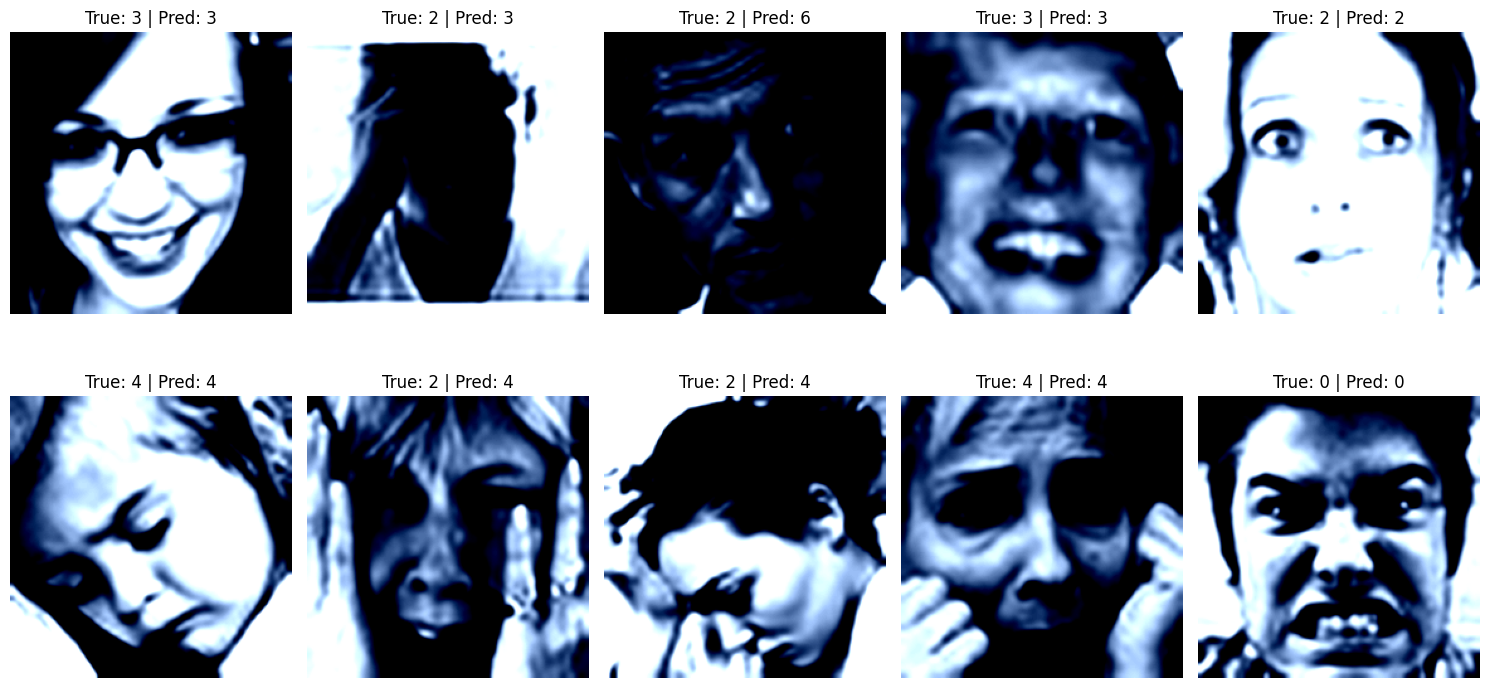

In [48]:
import matplotlib.pyplot as plt
import random

# ƒê·∫∑t m√¥ h√¨nh v·ªÅ ch·∫ø ƒë·ªô eval
model.eval()

# L·∫•y 1 batch t·ª´ val_loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# D·ª± ƒëo√°n
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Ch·ªçn ng·∫´u nhi√™n 10 ·∫£nh
indices = random.sample(range(len(images)), 10)

# Hi·ªÉn th·ªã ·∫£nh
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    image = images[idx].cpu().permute(1, 2, 0)  # t·ª´ (C, H, W) ‚Üí (H, W, C)
    true_label = labels[idx].item()
    predicted_label = preds[idx].item()

    plt.subplot(2, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray' if image.shape[2] == 1 else None)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## L∆∞u model

In [49]:
torch.save(model.state_dict(),"Final_Project_DPL302m_EfficientNet_V2S_70acc.h5")
print(" Ho√†n t·∫•t ")

 Ho√†n t·∫•t 
